## Data Cleaning and Exploration for Property Price Prediction


### 1. Introduction

In this notebook, we will perform data cleaning on a real estate dataset. The goal is to prepare the data for a future machine learning model that predicts property prices.

### Objectives:

    1.	Load the dataset and required libraries.
    2.	Analyze missing values and visualize them.
    3.	Identify critical columns to keep and non-critical columns to drop.
    4.	Handle missing values appropriately.
    5.	Categorize data to facilitate imputation.
    6.	Impute missing values using grouped data.
    7.	Show deductions based on data patterns.
    8.	Handle outliers and visualize their impact.


### 2. Load the File and Required Libraries


In [98]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set visualization style
sns.set_style('whitegrid')
%matplotlib inline

# Load the dataset
df = pd.read_csv('immoweb_data.csv')

# Display the first few rows
df.head()

,Price,Locality,Type_of_Property,Subtype_of_Property,State_of_the_Building,Number_of_Rooms,Living_Area,Fully_Equipped_Kitchen,Furnished,Open_fire,...,Terrace_Area,Garden,Garden_Area,Surface_of_the_Land,Surface_area_plot_of_land,Number_of_Facades,Swimming_Pool,Disabled_Access,Lift,Municipality
0,475000,1800,APARTMENT,LOFT,NaN,3,400.0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vilvoorde
1,895000,2000,APARTMENT,DUPLEX,NaN,3,286.0,1,NaN,NaN,...,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Antwerpen
2,685000,1180,APARTMENT,PENTHOUSE,JUST_RENOVATED,2,127.0,0,NaN,NaN,...,55.0,NaN,NaN,NaN,NaN,4.0,0.0,0.0,1.0,Uccle
3,289000,8680,APARTMENT,APARTMENT,JUST_RENOVATED,3,120.0,0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Koekelare
4,775000,2980,HOUSE,VILLA,TO_BE_DONE_UP,4,350.0,0,0.0,NaN,...,NaN,NaN,NaN,NaN,3715.0,4.0,0.0,NaN,0.0,Zoersel


### 3. Analyzing Missing Values

We need to analyze the missing values in the dataset and visualize them to understand which columns have the most missing data.


/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_3763/2164067638.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MissingPercentage', y='Column', data=missing_df, palette='viridis')


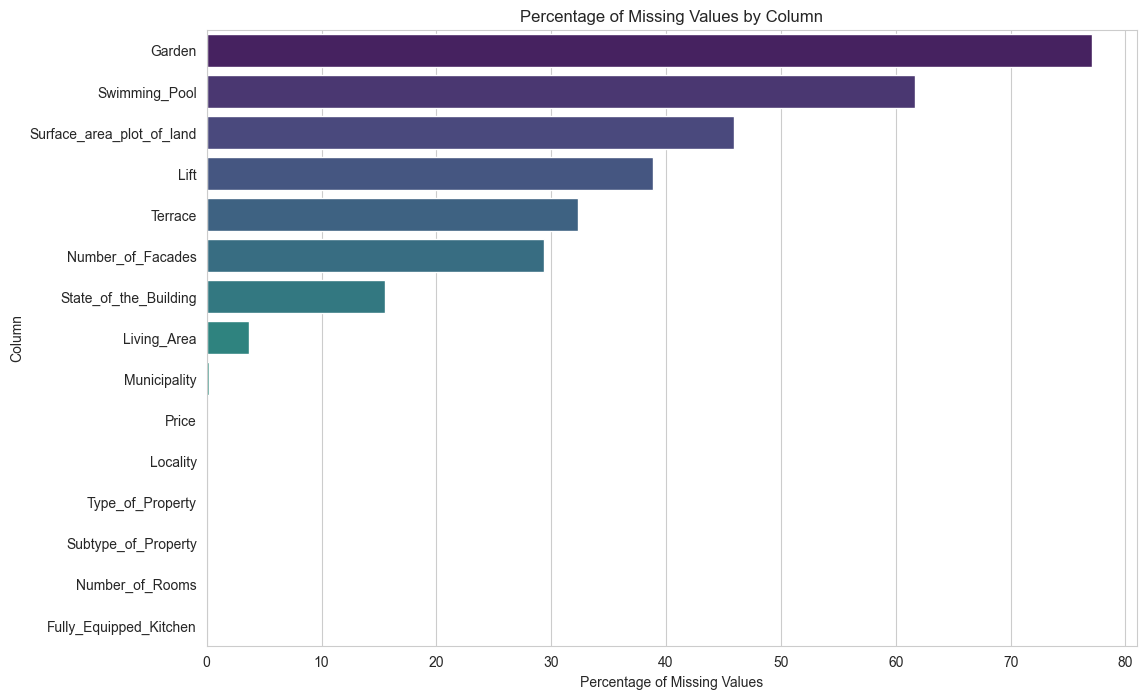

In [95]:
# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().mean() * 100

# Create a DataFrame for visualization
missing_df = pd.DataFrame({
    'Column': df.columns,
    'MissingPercentage': missing_percentage
}).sort_values(by='MissingPercentage', ascending=False)

# Reset index for better display
missing_df.reset_index(drop=True, inplace=True)

# Display the DataFrame
# Plotting the missing values
plt.figure(figsize=(12, 8))
sns.barplot(x='MissingPercentage', y='Column', data=missing_df, palette='viridis')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Column')
plt.show()

### 4. Identifying Critical and Non-Critical Columns

Based on domain knowledge and the analysis of missing values, we categorize the columns.

4.1 Critical Columns to Keep

These columns are essential for our analysis and model: - Garden - Terrace - Swimming_Pool - Price - Locality - Type_of_Property - Subtype_of_Property - Number_of_Rooms - Fully_Equipped_Kitchen

<b>Rationale</b>:
• These columns provide significant information that influences property prices.
• Even if they have missing values, we will attempt to fill them due to their importance.

4.2 Columns to Drop

These columns have too many missing values and add minimal value:
• Open_fire
• Garden_Area
• Terrace_Area
• Disabled_Access
• Surface_of_the_Land
• Furnished

Rationale:
• High percentage of missing values makes them unreliable.
• Their impact on price prediction is minimal compared to critical columns.


In [99]:
# Drop the columns
columns_to_drop = ['Open_fire', 'Garden_Area', 'Terrace_Area', 'Disabled_Access','Surface_of_the_Land','Furnished']
df = df.drop(columns=columns_to_drop)
        

#Drop columns with less than 5% of missing entries
threshold = 0.05 * len(df)
columns_low_missing_data = df.columns[df.isna().sum() < threshold]
df.dropna(subset=columns_low_missing_data, inplace=True)

# Verify the columns are dropped
df.columns

Index(['Price', 'Locality', 'Type_of_Property', 'Subtype_of_Property',
       'State_of_the_Building', 'Number_of_Rooms', 'Living_Area',
       'Fully_Equipped_Kitchen', 'Terrace', 'Garden',
       'Surface_area_plot_of_land', 'Number_of_Facades', 'Swimming_Pool',
       'Lift', 'Municipality'],
      dtype='object')

### 6. Handling Missing Values in Critical Columns

For Garden, Terrace, and Swimming_Pool: <br>
• Missing values are likely to mean the feature is absent. <br>
• We’ll fill missing values with 0 (False).


In [100]:
# Fill missing values with 0 for binary columns
binary_columns = ['Garden', 'Terrace', 'Swimming_Pool']
df[binary_columns] = df[binary_columns].fillna(0).astype(int)

### 7. Filling Missing Values for Categorical Data

We will fill missing values for categorical data using the mode based on similar entries grouped by <b>Subtype_of_Property</b>.


Defining a Function to Get Grouped Mode


In [101]:
def get_grouped_mode(dataframe, group, column):
    mode_series = dataframe.groupby(group)[column].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    return mode_series.to_dict()

Missing values in ‘Lift’ are filled based on the mode of ‘Lift’ within each ‘Subtype_of_Property’.


In [102]:
# Get the mode of 'Lift' for each 'Subtype_of_Property'
lift_dict = get_grouped_mode(df, 'Subtype_of_Property', 'Lift')

# Fill missing values
df['Lift'] = df['Lift'].fillna(df['Subtype_of_Property'].map(lift_dict))

# Print the mapping
print("Lift mode per Subtype_of_Property:")
print(lift_dict)

Lift mode per Subtype_of_Property:
{'APARTMENT': 1.0, 'APARTMENT_BLOCK': 0.0, 'BUNGALOW': 0.0, 'CASTLE': 0.0, 'CHALET': 0.0, 'COUNTRY_COTTAGE': 0.0, 'DUPLEX': 0.0, 'EXCEPTIONAL_PROPERTY': 0.0, 'FARMHOUSE': 0.0, 'FLAT_STUDIO': 1.0, 'GROUND_FLOOR': 1.0, 'HOUSE': 0.0, 'KOT': 1.0, 'LOFT': 1.0, 'MANOR_HOUSE': 0.0, 'MANSION': 0.0, 'MIXED_USE_BUILDING': 0.0, 'OTHER_PROPERTY': 0.0, 'PENTHOUSE': 1.0, 'SERVICE_FLAT': 1.0, 'TOWN_HOUSE': 0.0, 'TRIPLEX': 0.0, 'VILLA': 0.0}


### 8. Categorizing Municipalities into Regions

Due to the high number of unique values in ‘Locality’, we categorize them into broader regions using postal code patterns.


/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_3763/476270357.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=locality_counts.values, y=locality_counts.index, palette='viridis')


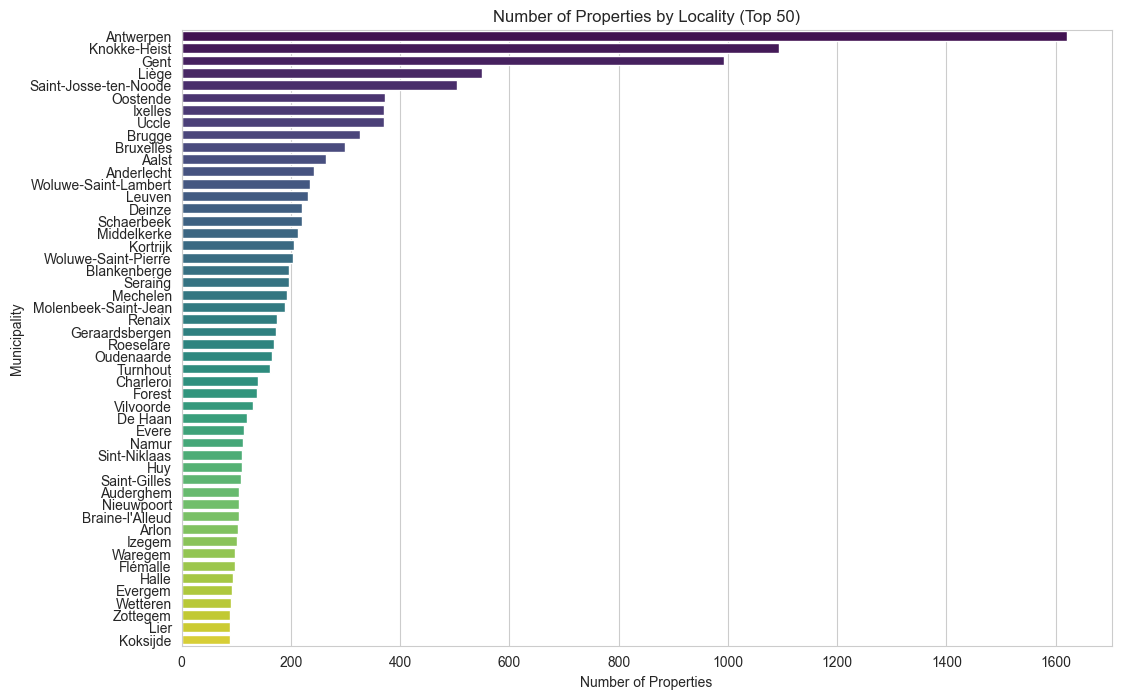

In [103]:
# Plot the number of properties per locality
plt.figure(figsize=(12, 8))
locality_counts = df['Municipality'].value_counts().head(50)  # Display top 40 for readability
sns.barplot(x=locality_counts.values, y=locality_counts.index, palette='viridis')
plt.title('Number of Properties by Locality (Top 50)')
plt.xlabel('Number of Properties')
plt.ylabel('Municipality')
plt.show()

In [104]:
# Define regions and their corresponding postal code patterns
provinces = ['Brussels Capital','Walloon Brabant', 'Flemish Brabant', 'Antwerp', 'Limburg','Liège','Namur','Hainaut','Luxembourg','West Flanders','East Flanders']
brussels_capital = '^10|^11|^12'
walloon_brabant = '^13|^14'
flemish_brabant = '^15|^16|^17|^18|^19|^30|^31|^32|^33|^34'
antwerp = '^20|^21|^22|^23|^24|^25|^26|^27|^28|^29'
limburg = '^35|^36|^37|^38|^39'
liège = '^40|^41|^42|^43|^44|^45|^46|^47|^48|^49'
namur = '^50|^51|^55|^53|^55|^55|^56|^57|^58|^59'
hainaut = '^60|^61|^62|63|^64|^65|^70|^71|^77|^73|^74|^75|^76|^77|^78|^79'
luxembourg = '^66|^67|^68|^69'
west_flanders = '^80|^81|^82|^83|^84|^85|^86|^87|^88|^89'
east_flanders = '^90|^91|^92|^93|^94|^95|^96|^97|^98|^99'

# Create conditions based on postal code patterns
conditions = [
    df["Locality"].astype(str).str.contains(brussels_capital),
    df["Locality"].astype(str).str.contains(walloon_brabant),
    df["Locality"].astype(str).str.contains(flemish_brabant),
    df["Locality"].astype(str).str.contains(antwerp),
    df["Locality"].astype(str).str.contains(limburg),
    df["Locality"].astype(str).str.contains(liege),
    df["Locality"].astype(str).str.contains(namur),
    df["Locality"].astype(str).str.contains(hainaut),
    df["Locality"].astype(str).str.contains(luxembourg),
    df["Locality"].astype(str).str.contains(west_flanders),
    df["Locality"].astype(str).str.contains(east_flanders),
]

# Assign regions based on conditions
df["Province"] = np.select(conditions, provinces, default='Other')

/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_3763/1232461508.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Province', data=df, order=df['Province'].value_counts().index, palette='pastel')


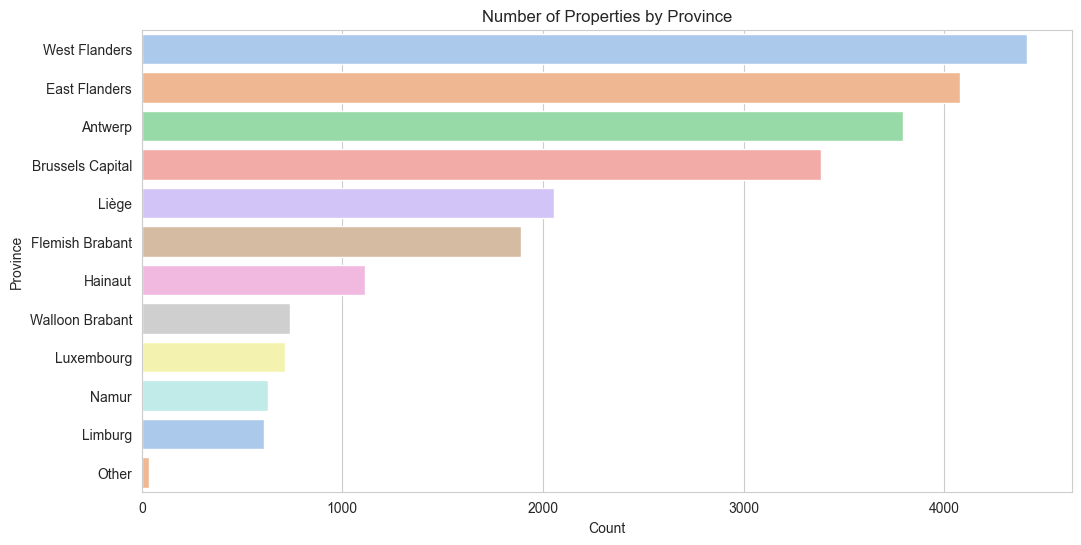

In [105]:
# Plot the distribution of properties by province
plt.figure(figsize=(12, 6))
sns.countplot(y='Province', data=df, order=df['Province'].value_counts().index, palette='pastel')
plt.title('Number of Properties by Province')
plt.xlabel('Count')
plt.ylabel('Province')
plt.show()

### 9. Categorizing ‘Price’ into Ranges

We will create price bins to categorize ‘Price’ and facilitate grouping.


In [106]:
# Define price bins and labels
price_bins = list(range(0, 300000, 100000))
price_bins += list(range(350000, 1100000, 2000000))
price_bins += list(range(1100000, 3000000, 1000000))
price_bins += [float('inf')]

price_labels = [
    f"{price_bins[i]}-{price_bins[i + 1]}" if price_bins[i + 1] != float('inf') else f"{price_bins[i]}+"
    for i in range(len(price_bins) - 1)
]

# Create 'Price_Group' column
df['Price_Group'] = pd.cut(df['Price'], bins=price_bins, labels=price_labels, include_lowest=True)

/var/folders/z6/vnwrtwgd7x5chl_2vn910h6r0000gn/T/ipykernel_3763/1048585313.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Price_Group', data=df, order=price_labels, palette='muted')


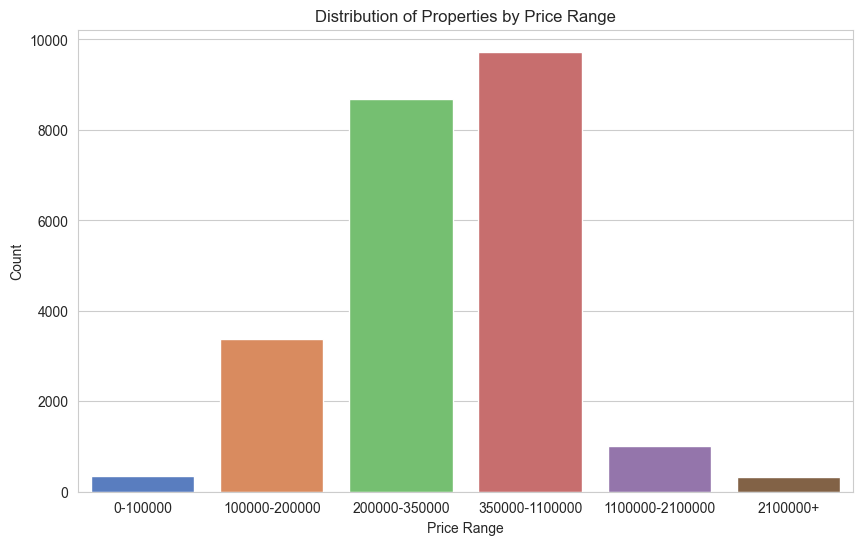

In [107]:
# Plot distribution of price groups
plt.figure(figsize=(10, 6))
sns.countplot(x='Price_Group', data=df, order=price_labels, palette='muted')
plt.title('Distribution of Properties by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.show()

### 10. Imputing ‘State_of_the_Building’

We aim to fill missing values in ‘State_of_the_Building’ using the mode within groups defined by ‘Province’ and ‘Price_Group’.


In [108]:
# Combine 'Province' and 'Price_Group' to create groups
df['Price_Group_Per_Region'] = df['Province'] + '_' + df['Price_Group'].astype(str)

# Calculate mode of 'State_of_the_Building' within each group
state_mode_dict = get_grouped_mode(df,'Price_Group_Per_Region','State_of_the_Building')

# Impute missing values
df['State_of_the_Building'] = df['State_of_the_Building'].fillna(df['Price_Group_Per_Region'].map(state_mode_dict))

In [109]:
group_2 = df.groupby('Type_of_Property')["Surface_area_plot_of_land"].count()
group_1 = df.groupby('Type_of_Property')["Surface_area_plot_of_land"].count()
print(group_2)

Type_of_Property
APARTMENT        0
HOUSE        12662
Name: Surface_area_plot_of_land, dtype: int64


### 11. Imputing ‘Number_of_Facades’

We will fill missing ‘Number_of_Facades’ values using the median number of facades for each ‘Subtype_of_Property’.


In [110]:
# Calculate median number of facades for each subtype
nb_of_facades_dict = df.groupby('Subtype_of_Property')['Number_of_Facades'].median().to_dict()

# Impute missing values
df['Number_of_Facades'] = df['Number_of_Facades'].fillna(df['Subtype_of_Property'].map(nb_of_facades_dict))

### 13. Removing Outliers

We will remove outliers using the Interquartile Range (IQR) method for key numerical columns.
Then compare the data.


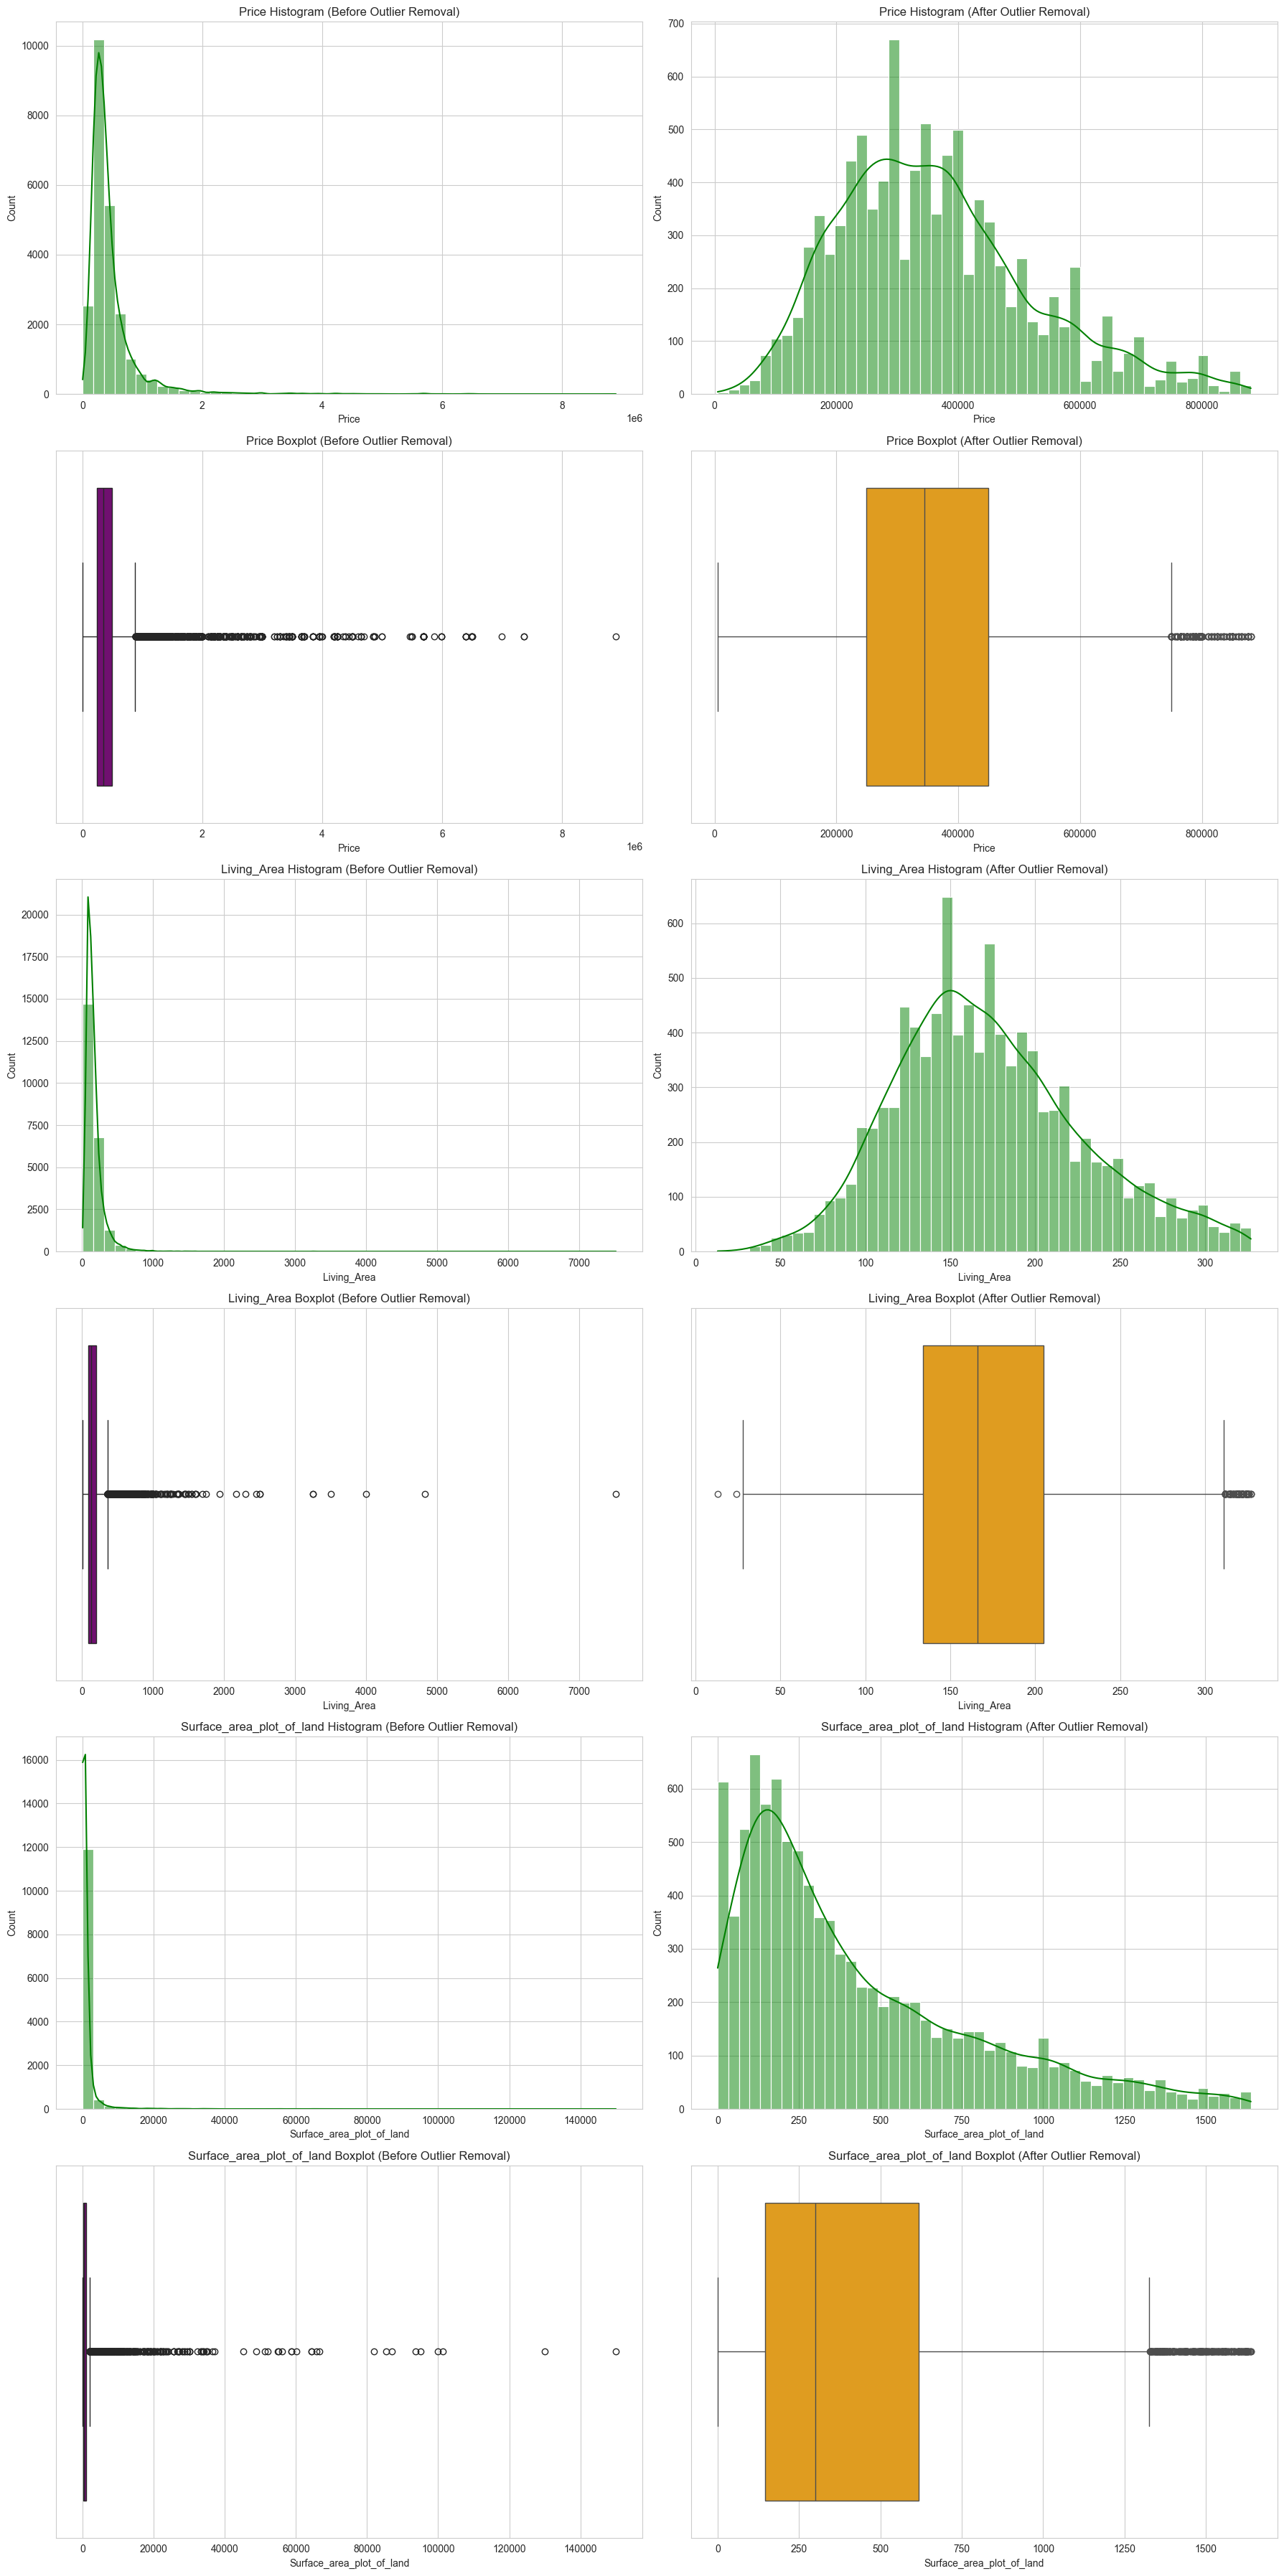

In [ ]:
# List of numerical columns to check for outliers
# Numerical columns
numerical_columns = ['Price', 'Living_Area', 'Surface_area_plot_of_land']

# Function to remove outliers
def remove_outliers(data, columns):
    for col in columns:
        if col in data.columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]
    return data

# Original dataset
df_original = df.copy()

# Remove outliers
df_no_outliers = remove_outliers(df.copy(), numerical_columns)

# Create a grid for side-by-side comparison (6 rows, 2 columns)
fig, axes = plt.subplots(6, 2, figsize=(18, 36))

# Plot histograms and boxplots for each column before and after outlier removal
for i, col in enumerate(numerical_columns):
    # Histogram before outlier removal
    sns.histplot(df_original[col], bins=50, kde=True, color='green', ax=axes[2 * i, 0])
    axes[2 * i, 0].set_title(f'{col} Histogram (Before Outlier Removal)')
    axes[2 * i, 0].set_xlabel(col)
    axes[2 * i, 0].set_ylabel('Count')

    # Histogram after outlier removal
    sns.histplot(df_no_outliers[col], bins=50, kde=True, color='green', ax=axes[2 * i, 1])
    axes[2 * i, 1].set_title(f'{col} Histogram (After Outlier Removal)')
    axes[2 * i, 1].set_xlabel(col)
    axes[2 * i, 1].set_ylabel('Count')

    # Boxplot before outlier removal
    sns.boxplot(x=df_original[col], color='orange', ax=axes[2 * i + 1, 0])
    axes[2 * i + 1, 0].set_title(f'{col} Boxplot (Before Outlier Removal)')
    axes[2 * i + 1, 0].set_xlabel(col)

    # Boxplot after outlier removal
    sns.boxplot(x=df_no_outliers[col], color='orange', ax=axes[2 * i + 1, 1])
    axes[2 * i + 1, 1].set_title(f'{col} Boxplot (After Outlier Removal)')
    axes[2 * i + 1, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

## 15. Conclusion

In this notebook, we have: <br>
• Loaded and explored the dataset. <br>
• Analyzed and visualized missing values. <br>
• Identified critical columns and columns to drop, with explanations. <br>
• Handled missing values appropriately, including imputations based on grouped data. <br>
• Categorized data to facilitate better imputation and analysis. <br>
• Made deductions based on data patterns to fill missing values logically. <br>
• Removed outliers and visualized their impact using both histograms and boxplots. <br>
• Prepared the dataset for future modeling tasks. <br>
